# Report - 03：服装分类

* 姓名：刘权祥

* 学号：2019300414

## 任务简介

* 任务类型：多分类

* 背景介绍：FashionMNIST 是一个替代 [MNIST 手写数字集](https://link.zhihu.com/?target=http%3A//yann.lecun.com/exdb/mnist/)的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。

  FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，**且不需要改动任何的代码**。

  这个数据集的样子大致如下（每个类别占三行）：

  ![fashion-mnist.jpg](images/fashion-mnist.jpg)


## 整体思路

### 选择网络模型

这个任务的本质就是一个**图像多分类问题**，我们需要对给出的图像进行多分类，并且对不支持类别进行判断。

考虑到在图像领域，用传统的神经网络并不合适，因为图像是由一个个像素点构成，对于灰度图，每个像素点有一个通道，而对于彩色图，每个像素点有三个通道，分别代表RGB颜色，这样的话一张图片中包含的信息会非常多。

举一个例子，假设一个图像的尺寸是（1，28，28），即代表这个图像的是一个通道为1，长宽均为28的图像（此处1代表灰色图像）。如果使用全连接的网络结构，即网络中的神经与与相邻层上的每个神经元均连接，那就意味着我们的网络输入层有28 * 28 =784个神经元，再假设hidden层采用了15个神经元，而最后的输出层使用10个神经元。那么简单计算一下，我们需要的参数个数(w和b)就有：784*15*10+15+10=117625个（15和10是一层中的偏置项），这个参数太多了，随便进行一次反向传播计算量都是巨大的，从计算资源和调参的角度都不建议用传统的神经网络。

而对于卷积神经网络（CNN），卷积层可以很好的利用图像本身具有的二维空间特征，比全连接网络仅仅考虑单个像素点的效果会更好，同时使用卷积核后图片的尺寸变小，方便后续计算；而池化层通过降采样的方式，在不影响图像质量的情况下，压缩图片，减少参数，这样计算量也会比全连接网络小很多。

因此，这个任务中我打算使用卷积神经网络（CNN）。

### 图片抓取与预处理

根据任务要求，我们需要编写爬虫程序，到淘宝等网站抓取一些衣服、鞋子的图片，并利用训练好的模型进行分类。但考虑到淘宝等购物网站的图片并不是那么的理想，图片上往往会有一些折扣或者其他信息，干扰较大，所以我打算主要从百度图片等网站来抓取图片。考虑到我对爬虫不是很了解，所以这里我打算从网上搜集相关的模板进行修改。

数据集里的图片背景很简单，看起来都是黑底的，而且每一类都是只有衣服，没有别的干扰因素。而我们抓取到的图片往往会复杂很多，比如是白底的，有模特穿着这件衣服，或者说一张图片里面有好几件衣服，甚至是抓取的图片和衣服并没有关系等，所以预处理是非常有必要的，不进行预处理直接给网络进行分类的话，效果肯定不好。我对OpenCV比较熟悉，所以后面我打算利用python-opencv对图片做一个简单的预处理。

### 对不支持类别进行判断

这个一开始我想的是直接多弄一个类别，叫做“不支持类别”，但是这样的话并潜在的图像几乎是无限的，并不好确定数据集，并且从网上了解到这样的做法后面可能会遇到很多未知的问题。

后面又了解到，在人脸识别领域，往往会先训练一个二分类器来区分是否是人脸，之后再进行人脸的分类，这样的做法能够使人脸的分类稳定。因此，我也打算训练一个二分类器，判断图片是不是服装，是服装就再进行服装的分类，否则就判定为“不支持类别”。


## 搭建CNN

### 参考资料：

torch.nn是专门为神经网络设计的模块化接口。nn构建于autograd之上，可以用来定义和运行神经网络。
nn.Module是nn中十分重要的类,包含网络各层的定义及forward方法。
定义自已的网络：
    需要继承nn.Module类，并实现forward方法。
    一般把网络中具有可学习参数的层放在构造函数__init__()中，
    不具有可学习参数的层(如ReLU)可放在构造函数中，也可不放在构造函数中(而在forward中使用nn.functional来代替)
   

只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
在forward函数中可以使用任何Variable支持的函数，毕竟在整个pytorch构建的图中，是Variable在流动。还可以使用
if,for,print,log等python语法.

注：Pytorch基于nn.Module构建的模型中，只支持mini-batch的Variable输入方式，
比如，只有一张输入图片，也需要变成 N x C x H x W 的形式：(batch channel H W) 

例如：

``` python
input_image = torch.FloatTensor(1, 28, 28)

input_image = Variable(input_image)

input_image = input_image.unsqueeze(0)   # 1 x 1 x 28 x 28
```

### 设计FashionCNN类

如何使用Sequential、如何设计卷积层、各个部分的作用等上课都讲过，这里根据课上讲的来搭建即可。

但是搭建的时候需要特别注意CNN中的输入输出公式，课上只讲了进过卷积或者池化之后矩阵发生的变化，这个变化具体怎么发生的、哪些因素在影响好像没讲太多，我在实现这个CNN时，因为没有搞清楚CNN的输入输出公式，在搭建网络的时候出了很多的问题。

在弄清楚这些函数的计算公式，知道输入输出的变化规律之后，搭建模型或者修改模型会方便很多。

#### 部分函数的计算公式

**nn.Conv2d**

class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

二维卷积层, 输入的尺度是(N, C_in, H, W)，输出尺度（N, C_out, H_out, W_out）。

计算公式：
    
    out=（input+2∗padding−kernel_size)/stride+1
    
**nn.MaxPool2d**

class torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

计算公式：

    out=(input+2∗padding−kernel_size)/stride+1


In [37]:
import torch.nn as nn

"""
Notes:

    torch.nn是专门为神经网络设计的模块化接口。nn构建于autograd之上，可以用来定义和运行神经网络。
    nn.Module是nn中十分重要的类,包含网络各层的定义及forward方法。
    定义自已的网络：
        需要继承nn.Module类，并实现forward方法。
        一般把网络中具有可学习参数的层放在构造函数__init__()中，
        不具有可学习参数的层(如ReLU)可放在构造函数中，也可不放在构造函数中(而在forward中使用nn.functional来代替)
        
        只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
        在forward函数中可以使用任何Variable支持的函数，毕竟在整个pytorch构建的图中，是Variable在流动。还可以使用
        if,for,print,log等python语法.
        
        注：Pytorch基于nn.Module构建的模型中，只支持mini-batch的Variable输入方式，
        比如，只有一张输入图片，也需要变成 N x C x H x W 的形式：(batch channel H W) 
        
        input_image = torch.FloatTensor(1, 28, 28)
        input_image = Variable(input_image)
    input_image = input_image.unsqueeze(0)   # 1 x 1 x 28 x 28
"""


class FashionCNN(nn.Module):

    # 在设计的时候，注意CNN里面的输入输出公式！！！
    def __init__(self):
        super(FashionCNN, self).__init__()

        # 第一层卷积
        # 输入[1,28,28]
        self.layer1 = nn.Sequential(
            # 卷积层
            #   padding是边缘填充，可以分为四类：零填充，常数填充，镜像填充，重复填充。
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # 归一化处理https://zhuanlan.zhihu.com/p/205453986
            #   在卷积神经网络的卷积层之后总会添加BatchNorm2d进行数据的归一化处理
            #   这使得数据在进行Relu之前不会因为数据过大而导致网络性能的不稳定
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 池化层
            # 　池化层是夹在连续的卷积层的中间层，池化层可以非常有效地缩小矩阵的尺寸。从而减少最后全连接层中的参数。
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第二层卷积
        # 输入[32,14,14]https://img-blog.csdnimg.cn/20200604155746947.bmp
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 第三层卷积
        # 输入[128，6，6]
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 防止过拟合
        self.drop = nn.Dropout2d(0.25)

        # 全连接层
        # 输入[64,2，2]
        self.fc1 = nn.Linear(in_features=64 * 2 * 2, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)
        self.fc4 = nn.Softmax()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)

        return out


## 训练CNN

### 引入库

In [38]:
import copy
from itertools import chain

import matplotlib.pyplot as plt
# import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch.utils.data import Dataset

如果GPU可用，则使用

In [39]:
# 尝试使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 加载数据集

虽然提供了.npy格式的数据集，但是里面的图片是整型的，不是浮点数型的，用来训练的话还需要归一化。

这里我觉得使用torch.utils.data里面的Dataset会方便一些，因此采用了这种方法加载数据集。

In [40]:
# 加载数据集
train_set = torchvision.datasets.FashionMNIST("./src/data", download=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./src/data", download=True, train=False,
                                             transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

/home/immortalqx/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 加载模型、定义训练变量

In [11]:
# 加载模型
model = FashionCNN()
model.to(device)
# 使用交叉熵损失函数
error = nn.CrossEntropyLoss()
# 定义学习率
learning_rate = 0.0005
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 循环次数
num_epochs = 5
# 迭代次数
count = 0

# 是否画图
display = True

# 最小迭代次数
min_epochs = 1
# 最小的损失
min_loss = 0.2
# 最优模型
best_model = None

# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

### 进行训练

In [12]:
for epoch in range(num_epochs):
    # 　分批次加载数据集
    for train_images, train_labels in train_loader:
        # for i in range(len(train_images_list) // 100):
        # Transferring images and labels to GPU if available
        # train_images = torch.tensor(train_images_list[i * 100:(i + 1) * 100])
        # train_labels = torch.tensor(train_labels_list[i * 100:(i + 1) * 100])
        train_images, train_labels = train_images.to(device), train_labels.to(device)

        train = Variable(train_images.view(100, 1, 28, 28))
        train_labels = Variable(train_labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, train_labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        # Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

        # Testing the model
        if not (count % 50):  # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for test_images, test_labels in test_loader:
                # for j in range(len(test_images_list) // 100):
                #     test_images = torch.tensor(test_images_list[i * 100:(i + 1) * 100])
                #     test_labels = torch.tensor(test_labels_list[i * 100:(i + 1) * 100])
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                labels_list.append(test_labels)

                test_real = Variable(test_images.view(100, 1, 28, 28))

                outputs = model(test_real)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == test_labels).sum()

                total += len(test_labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

        # 一般可以默认验证集的损失函数值由下降转向上升（即最小值）处，模型的泛化能力最好。
        if epoch >= min_epochs and loss.data <= min_loss:
            print("update best model")
            min_loss = loss.data
            best_model = copy.deepcopy(model)

Iteration: 500, Loss: 0.4136478304862976, Accuracy: 88.0999984741211%
update best model
update best model
update best model
update best model
update best model
update best model
update best model
Iteration: 1000, Loss: 0.3463529646396637, Accuracy: 89.75%
update best model
Iteration: 1500, Loss: 0.18912623822689056, Accuracy: 88.80999755859375%
update best model
update best model
update best model
Iteration: 2000, Loss: 0.15128815174102783, Accuracy: 90.06999969482422%
update best model
update best model
Iteration: 2500, Loss: 0.15940940380096436, Accuracy: 89.0%
update best model
update best model
Iteration: 3000, Loss: 0.1301259845495224, Accuracy: 90.20999908447266%


### 保存最优模型

In [18]:
torch.save(best_model.state_dict(), "best_model.pth")

### 画出迭代中的损失变化

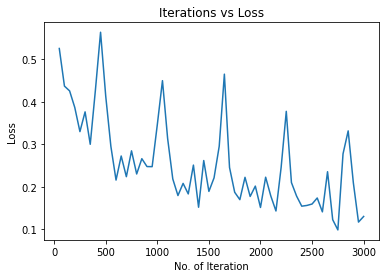

In [19]:
# 画出迭代中的损失
plt.figure(1)
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

### 画出迭代中的准确度变化

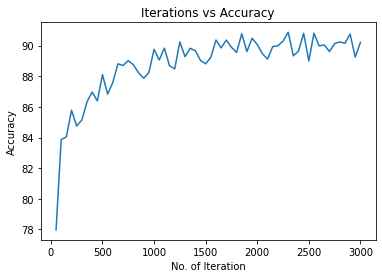

In [20]:
plt.figure(2)
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

### 画出混淆矩阵

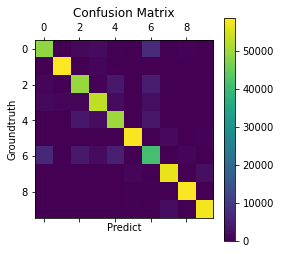

In [21]:
predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))
cm = confusion_matrix(labels_l, predictions_l)
plt.matshow(cm)
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('Groundtruth')
plt.xlabel('Predict')
plt.show()

## 从百度图片爬取图片

In [ ]:
import os
import re

import requests

"""
通过爬虫获取图片

从网上找的一个爬虫例子，然后改了改就直接用了
考虑到淘宝等购物网站搜到的图片比较复杂，干扰信息过多，所以爬取了百度图片
"""


def get_label(index):
    output_mapping = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    return output_mapping[index]


def get_images_from_baidu(keyword, page_num, save_dir):
    # UA 伪装：当前爬取信息伪装成浏览器
    # 将 User-Agent 封装到一个字典中
    # 【（网页右键 → 审查元素）或者 F12】 → 【Network】 → 【Ctrl+R】 → 左边选一项，右边在 【Response Hearders】 里查找
    header = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/78.0.3904.108 Safari/537.36'}
    # 请求的 url
    url = 'https://image.baidu.com/search/acjson?'
    n = 0
    for pn in range(0, 30 * page_num, 30):
        # 请求参数
        param = {'tn': 'resultjson_com',
                 # 'logid': '7603311155072595725',
                 'ipn': 'rj',
                 'ct': 201326592,
                 'is': '',
                 'fp': 'result',
                 'queryWord': keyword,
                 'cl': 2,
                 'lm': -1,
                 'ie': 'utf-8',
                 'oe': 'utf-8',
                 'adpicid': '',
                 'st': -1,
                 'z': '',
                 'ic': '',
                 'hd': '',
                 'latest': '',
                 'copyright': '',
                 'word': keyword,
                 's': '',
                 'se': '',
                 'tab': '',
                 'width': '',
                 'height': '',
                 'face': 0,
                 'istype': 2,
                 'qc': '',
                 'nc': '1',
                 'fr': '',
                 'expermode': '',
                 'force': '',
                 'cg': '',  # 这个参数没公开，但是不可少
                 'pn': pn,  # 显示：30-60-90
                 'rn': '30',  # 每页显示 30 条
                 'gsm': '1e',
                 '1618827096642': ''
                 }
        request = requests.get(url=url, headers=header, params=param)
        if request.status_code == 200:
            print('Request success.')
        request.encoding = 'utf-8'
        # 正则方式提取图片链接
        html = request.text
        image_url_list = re.findall('"thumbURL":"(.*?)",', html, re.S)
        print(image_url_list)
        # # 换一种方式
        # request_dict = request.json()
        # info_list = request_dict['data']
        # # 看它的值最后多了一个，删除掉
        # info_list.pop()
        # image_url_list = []
        # for info in info_list:
        #     image_url_list.append(info['thumbURL'])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for image_url in image_url_list:
            image_data = requests.get(url=image_url, headers=header).content
            with open(os.path.join(save_dir, f'{n:06d}.jpg'), 'wb') as fp:
                fp.write(image_data)
            n = n + 1

for i in range(10):
    fashion = get_label(i)
    save_dir = "./ImageSet/" + fashion
    print('Start get images of %s' % fashion)
    # 使用try和finally主要是怕搜到的图片页数没有这么多，然后提前终止了
    try:
        get_images_from_baidu(keyword=fashion, page_num=5, save_dir=save_dir)
    finally:
        print("error!")
    print('Get images of %s finished.' % fashion)

## 图片预处理

FashionMNIST数据集里面的图片是28\*28的灰度图，因此我们设计的卷积神经网络FashionCNN第一层的输入就是1\*28\*28。

而我们从网上爬取到的图片很难满足这样的要求，因此我们需要进行图片预处理之后才可以让FashionCNN来进行分类。

**预处理步骤:**

1. **整理爬取的图片，仅保留有单件服装的图片**
   
    从我们做的问题开始考虑，因为我们做的是服装分类问题，不是服装检测问题，而我们的数据集里面基本都是只有一件服装的，所以可以认为我们做的是对单件服装进行分类的问题。
    
    但爬取到的图片里面有的有好多件服装，有的包括了其他种类的服装（比如搜索的Tshirt，但爬取到的是穿Tshirt的模特的全身照），还有的服装并不是我们搜索的服装，因此我们需要先整理爬取的图片，保证爬取的图片是没有问题的。
    
    这一步的话，就只能人为的整理了，比较费时费力。
    

2. **读取文件夹下所有的图片，进行“前景提取”（服装部分处理成白色，其余部分处理为黑色）**

    **这里可能是整个过程中花的时间最多的地方，尝试的最多的地方。**
    
    最开始不进行任何处理，只是简简单单的转化为灰度图并且调整分辨率，用训练的网络进行分类时正确率只有8%多一点，好像效果还没有随机的好，随机能到10%左右。
    
    之后就尝试了阈值化处理，这里主要也是把白色的背景处理成黑色，其余地方保留像素值或者处理成白色，这样的效果能好一些，到了30%左右。
    
    然后上网查到了OpenCV的grabCut函数，听说这个做前景提取效果很好，但是在我尝试的时候，处理速度太慢了，而且效果也没有我想的那么理想，这个就直接放弃了。
    
    最后我是打算用轮廓检测的方法来做，**具体的步骤是：**

    1. 阈值化处理

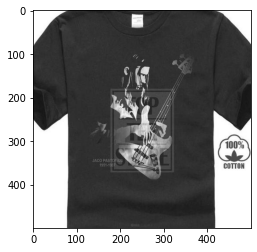

In [17]:
import cv2.cv2 as cv
import os                  
import numpy as np
import matplotlib.pyplot as plt      

image=cv.imread("src/test/T-shirt/005.jpg",0)

plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

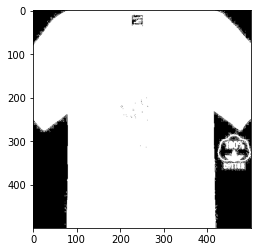

In [18]:

_, img_binary = cv.threshold(image, 250, 255, cv.THRESH_BINARY_INV)

plt.imshow(cv.cvtColor(img_binary,cv.COLOR_BGR2RGB))

    2. 进行轮廓检测并且填充轮廓，处理掉轮廓面积过大的图片

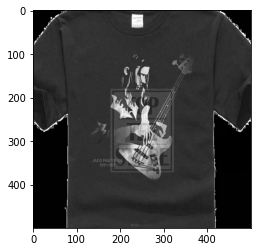

In [24]:
# 尝试通过轮廓检测的方式来优化处理结果
mask = np.ones_like(img_binary)
# 找到所有的轮廓
contours, _ = cv.findContours(img_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
area = []
# 找到最大的轮廓
for k in range(len(contours)):
    area.append(cv.contourArea(contours[k]))
max_idx = np.argmax(np.array(area))

# 如果轮廓几乎和图片一样大，说明很可能是被阈值化成全白或者全黑的图，应该舍去
w, h = img_binary.shape[1::-1]
if area[max_idx] < 0.9 * w * h:
    # 填充最大的轮廓
    cv.drawContours(mask, contours, max_idx, 255, cv.FILLED)
    del area
    # 利用轮廓填充的mask来提取服装
    img_end=mask & image
    plt.imshow(cv.cvtColor(img_end, cv.COLOR_BGR2RGB))
else:
    print("轮廓检测填充方法失败！")

    3. 调整分辨率并进行归一化处理

[[  1   1   1  91  49  37  35  46  44  42  43  48  34  54  34  36  50  36
   51  47  46  44  36  51 242   1   1   1]
 [  1   1  51  54  41  51  49  52  52  45  46  52  57 241  53  44  47  50
   51  51  52  53  54  60  49  33   1   1]
 [  1 219  48  57  59  50  51  50  49  49  53  46  46  43  43  48  42  46
   52  47  51  53  49  53  45  51  70   1]
 [  1  52  46  30  55  48  50  52  53  52  49  49  45  42  43  44  46  52
   50  50  48  47  48  46  47  48  47   0]
 [ 53  52  49  42  49  51  50  53  50  50  48  50  47  46  45  46  48  52
   50  51  45  48  44  30  48  48  52  52]
 [ 48  48  47  43  51  53  52  48  48  51  49  49  47  48  47  50  48  52
   48  49  48  48  47  39  47  48  49  45]
 [ 54  50  50  47  49  53  46  48  54  51  51  50  50  48  50  48  48  47
   77  83  61  48  47  38  47  48  50  49]
 [ 57  48  50  50  50  51  46  50  49  50  49  52  45 188 222  49  49  49
   50  77  50  48  47  41  48  46  48  49]
 [ 49  49  51  50  48  49  47  49  49  48  49  47 114 204  58  4

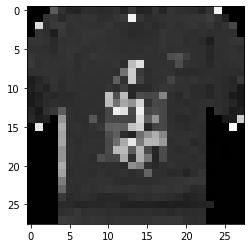

In [25]:
img_end = cv.resize(img_end, (28, 28))

plt.imshow(cv.cvtColor(img_end, cv.COLOR_BGR2RGB))
print(img_end)

[[0.004      0.004      0.004      0.36400002 0.19600001 0.148
  0.14       0.18400002 0.17600001 0.16800001 0.172      0.192
  0.136      0.216      0.136      0.14400001 0.2        0.14400001
  0.20400001 0.18800001 0.18400002 0.17600001 0.14400001 0.20400001
  0.96800005 0.004      0.004      0.004     ]
 [0.004      0.004      0.20400001 0.216      0.164      0.20400001
  0.19600001 0.208      0.208      0.18       0.18400002 0.208
  0.22800002 0.96400005 0.21200001 0.17600001 0.18800001 0.2
  0.20400001 0.20400001 0.208      0.21200001 0.216      0.24000001
  0.19600001 0.132      0.004      0.004     ]
 [0.004      0.87600005 0.192      0.22800002 0.23600002 0.2
  0.20400001 0.2        0.19600001 0.19600001 0.21200001 0.18400002
  0.18400002 0.172      0.172      0.192      0.16800001 0.18400002
  0.208      0.18800001 0.20400001 0.21200001 0.19600001 0.21200001
  0.18       0.20400001 0.28       0.004     ]
 [0.004      0.208      0.18400002 0.12       0.22000001 0.192
  0.2    

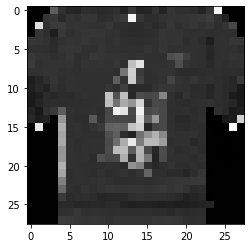

In [26]:
new_image = np.zeros(img_end.shape, dtype=np.float32)
cv.normalize(img_end, new_image, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.imshow(cv.cvtColor(new_image, cv.COLOR_BGR2RGB))
print(new_image)

4. **整合图片处理的过程，并且打上标签**
    
    前面的处理都是针对图片的，没有提到图片标签的问题。因为我这里的爬虫爬取到图片之后，每一种图片会放到不同的文件夹，所以可以直接根据文件夹名称来知道图片的种类。我们只需要在读取图片的同时根据读取的文件夹来打上标签即可。（这部分代码略）
    
    预处理的所有代码整理成了函数在processImage.py中

## 对不支持类别进行判断

这个部分我网上找了很多的资料，了解了比较多的内容。如果我们要在这个服装分类上再加一个不支持类别的判断的话，这个分类问题就从闭集分类问题变成了开集分类问题。其中：

    闭集分类问题：集合S包含N个有限类别，且该N个类别有具体标签，闭集分类问题即划分这N个类别

    开集分类问题：集合S包含N个有具体标签的有限类别，且S包含K个有限或无限未知类别，开集分类问题即划分这N个类别且拒绝这K个未知类别
    
由于我们手头上只有服装的数据集，不支持类别的数据几乎没有，而且就算制作，不支持类别的数据可能是无穷无尽的，并不好制作。所以我一开始的想法就是利用OCSVM（one class support vector machine,即单类支持向量机）来做一个分类判断，如果不是服装就拒绝后面的分类，如果是服装就再进行服装分类。

OCSVM该模型将数据样本通过核函数映射到高维特征空间，使其具有更良好的聚集性，在特征空间中求解一个最优超平面实现目标数据与坐标原点的最大分离。这个模型适合样本不均衡的情况，样本被映射到新的空间后，大类样本能够聚成簇(cluster)，小类样本作为异常点在簇之外，这个簇可以用超平面刻画。

不过，因为目前已经在这个项目上面花了比较多的时间，实现OCSVM的过程中还需要对图像进行特征提取等，这些目前还没做。所以我先尝试了一下直接通过CNN最后一层输出的每个类的概率来判断是否是不支持类别。（如果后面能够提前完成另外两个报告再回来把这部分做好！）

这种方法的思想很简单：判断输出向量里面最大值与平均值的差是不是过小、最大值是不是过小来看CNN是不是明显的做出分类。这个部分的代码如下所示：

In [41]:
def judgeOutLiner(outputs, sigma=0.5, threshold1=0.9, threshold2=0.5):
    labels = []
    sum = 0
    for i in range(len(outputs)):
        label = outputs[i]
        if (np.max(label) - np.mean(label)) < sigma and np.max(label) < threshold1 or np.max(label) < threshold2:
            # print("out liners!")
            labels.append(10)
            sum += 1
        else:
            # print("type is:", np.argmax(label))
            labels.append(np.argmax(label))
    # print(labels)
    return np.array(labels), sum

## 测试CNN

首先要引用图像预处理的代码和可视化部分的代码，以及其他库

In [42]:
from src.processImage import get_dataset
from src.fashion_tools import display_result

### 对FashionMNIST测试集进行测试

/home/immortalqx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 83.73999786376953%
不支持类别个数: 176


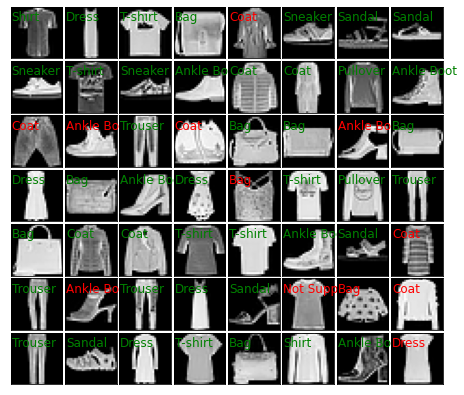

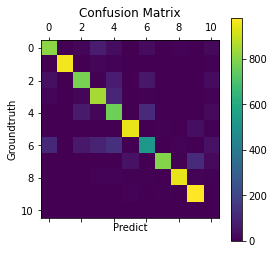

In [43]:
display=True

# 加载模型
model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load('./src/new_best_model.pth'))

total = 0
correct = 0
out_liner = 0

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

test_images = None
test_labels = None
predictions = None

for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    labels_list.append(test_labels)

    test_real = Variable(test_images.view(100, 1, 28, 28))

    outputs = model(test_real)

    # predictions = torch.max(outputs, 1)[1].to(device)
    predictions, out = judgeOutLiner(outputs.cpu().detach().numpy())
    predictions = torch.from_numpy(predictions).to(device)
    out_liner += out

    predictions_list.append(predictions)

    correct += (predictions == test_labels).sum()
    total += len(test_labels)

accuracy = correct * 100 / total

print("Accuracy: {}%".format(accuracy))
print("不支持类别个数: {}".format(out_liner))

if display:
    display_result(test_images.view(-1, 28, 28).cpu().detach().numpy(), test_labels.cpu().detach().numpy(),
                       predictions.cpu().detach().numpy(), "test_demo")
    # 画出混淆矩阵
    predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
    labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
    predictions_l = list(chain.from_iterable(predictions_l))
    labels_l = list(chain.from_iterable(labels_l))
    cm = confusion_matrix(labels_l, predictions_l)
    plt.matshow(cm)
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.ylabel('Groundtruth')
    plt.xlabel('Predict')

    plt.show()

### 对爬虫得到的数据集进行测试

Load 71 images of: T-shirt
Load 64 images of: Trouser
Load 78 images of: Pullover
Load 57 images of: Dress
Load 59 images of: Coat
Load 73 images of: Sandal
Load 22 images of: Shirt
Load 6 images of: Sneaker
Load 73 images of: Bag
Load 67 images of: Ankle Boot
Load 3 images of: Others


/home/immortalqx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 61.000003814697266%
不支持类别个数: 22


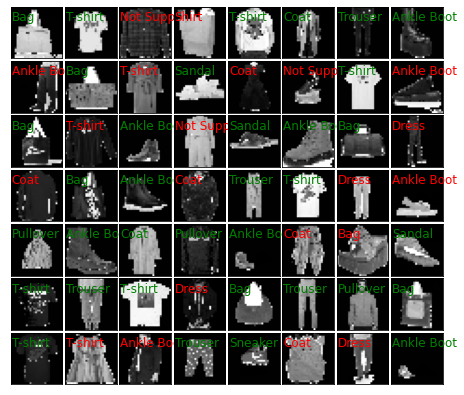

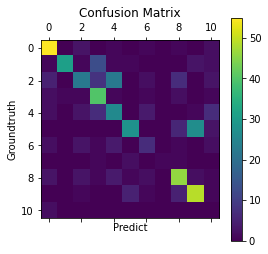

In [46]:
display=True

images, labels = get_dataset("./src/test/", True,True, 3000)
# 加载模型
model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load('./src/new_best_model.pth'))

total = 0
correct = 0
out_liner = 0

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

test_images = None
test_labels = None
predictions = None

for i in range(len(images) // 100):
    test_images = torch.tensor(images[i * 100:(i + 1) * 100])
    test_labels = torch.tensor(labels[i * 100:(i + 1) * 100])
    labels_list.append(test_labels)
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_real = Variable(test_images.view(100, 1, 28, 28))

    outputs = model(test_real)
    # predictions = torch.max(outputs, 1)[1].to(device)
    predictions, out = judgeOutLiner(outputs.cpu().detach().numpy())
    predictions = torch.from_numpy(predictions).to(device)
    out_liner += out

    predictions_list.append(predictions)

    correct += (predictions == test_labels).sum()
    total += len(test_labels)

accuracy = correct * 100 / total
print("Accuracy: {}%".format(accuracy))
print("不支持类别个数: {}".format(out_liner))

if display:
    display_result(test_images.view(-1, 28, 28).cpu().detach().numpy(), test_labels.cpu().detach().numpy(),
                       predictions.cpu().detach().numpy(), "test_real")
    # 画出混淆矩阵
    predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
    labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
    predictions_l = list(chain.from_iterable(predictions_l))
    labels_l = list(chain.from_iterable(labels_l))
    cm = confusion_matrix(labels_l, predictions_l)
    plt.matshow(cm)
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.ylabel('Groundtruth')
    plt.xlabel('Predict')

    plt.show()

## 总结

这是我写的第一个大作业，断断续续写了大概一个多月，期间主要是在学习pytorch的使用方法。

通过这个项目，我学习了如何使用pytorch搭建卷积神经网络（CNN），同时也了解并且尝试了很多图像预处理方法，当然也熟悉了爬虫的那一套流程。

整个过程中花费时间最多的可能是图像预处理这个部分，因为训练好的CNN在FashionMNIST数据集上面的表现非常好，对测试集预测的准确率可以达到90以上，但是对我从网上爬取的图片准确率却直接跌倒了10%以下，这甚至还不如随机分类（大概也是10%的准确率），所以我觉得应该对爬取的图片进行一些处理之后再给CNN进行分类。而期间尝试了很多很有意思的方法，甚至还考虑了学习的方法，不过比较担心时间不够所以就放弃了，不过感觉最后达到的效果也还可以，通过预处理之后的准确率能达到40%以上，而对爬取的部分图片进行训练之后，准确率可以达到70%，比之前不进行处理的效果好多了。

不过这个项目比较遗憾的地方就是对不支持类别的判断上面，这里也花了不少时间，但因为在这个项目上面花的时间太长了，所以做了个很简单的判断方法，而通过OCSVM的判断方法打算暂时搁置，等后面有时间再做。